# Used the trained embeddings to classify hate-speeches
This notebook creates a neural classifier.

### Input:
    - Word-embeddings.
    - Training data.

### Output:
    - A binary classifier.
    - Evaluation on test data.

## Import libraries

In [1]:
# Imports
import re
import string
import json
from datetime import datetime
from collections import defaultdict, Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.nn import Module
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.init import xavier_uniform_
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

from nltk.corpus import stopwords

device = 'cuda'

import random

torch.manual_seed(123)
torch.cuda.manual_seed(234)
np.random.seed(345)
random.seed(456)
torch.manual_seed(567)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

## Load data

In [2]:
# train data
train_df = pd.read_csv('save/hindi_train_preprocessed.csv')
train_sentences = [[int(s) for s in text.split()] for text in train_df['sentence']]
train_df['hate'] = (train_df['task_1'] == 'HOF').astype(int)
train_labels = train_df['hate'].to_numpy()

# test data
test_df = pd.read_csv('save/hindi_test_preprocessed.csv')
test_sentences = [[int(s) for s in text.split()] for text in test_df['sentence']]
test_df['hate'] = (test_df['task_1'] == 'HOF').astype(int)
test_labels = test_df['hate'].to_numpy()

# word <-> convertion
with open('save/hindi_word_to_int_dict.json', 'r') as f:
    word_to_int = json.load(f)
with open('save/hindi_int_to_word_dict.json', 'r') as f:
    int_to_word = json.load(f)
    int_to_word = {int(k) : v for k, v in int_to_word.items()}

# word-counter
with open('save/hindi_word_counter.json', 'r') as f:
    word_counter = json.load(f)
    
vocab_size = len(word_to_int)
print('vocab size:', vocab_size)

vocab size: 19379


In [3]:
print('sample data:')
print('train:')
print(train_sentences[:2])
print(train_labels[:2])
print('test:')
print(test_sentences[:2])
print(test_labels[:2])

sample data:
train:
[[13596, 17167, 16799, 14350, 1650, 15814, 16162, 253, 120], [17600, 15743, 11530, 11086, 17053, 1448, 19075, 17600, 1345, 17265, 11072]]
[0 1]
test:
[[16688, 5897, 15598, 5726, 6754, 11324, 11068, 19029, 250], [769, 749, 11095, 11145, 15755, 14938, 14353, 7944, 15766, 1031, 8094, 15169, 8045, 1443, 12551, 17146, 5251, 19029, 15491, 19029]]
[0 1]


## Hyper-parameters

In [4]:
embedding_path = 'save/hindi_embedding_weights_10_negfac.pt'
embedding_size = 300
att_dim = 150
learning_rate = 5e-5
batch_size = 32
epochs = 30

## Build datasets

In [5]:
class HOFDataset(Dataset):
    def __init__(self, sentences, labels):
        self.data = []
        for sentence, label in zip(sentences, labels):
            if len(sentence):
                self.data.append(
                    (torch.tensor(sentence, dtype=torch.long),
                     torch.tensor(label, dtype=torch.float))
                )
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return self.data[index]
    
def preprocess_batch(batch):
    texts, labels = list(zip(*batch))
    seq_lens = torch.tensor([len(text) for text in texts], dtype=torch.long)
    texts = pad_sequence(texts, padding_value=0)
    labels = torch.tensor(labels).unsqueeze(1)

    seq_lens, sorted_idx = seq_lens.sort(descending=True)
    texts = texts[:,sorted_idx]
    labels = labels[sorted_idx]
    return texts, seq_lens, labels

train_dataset = HOFDataset(train_sentences, train_labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, 
                          shuffle=True, collate_fn=preprocess_batch)

test_dataset = HOFDataset(test_sentences, test_labels)
test_loader = DataLoader(test_dataset, batch_size=batch_size, 
                         shuffle=False, collate_fn=preprocess_batch)

## Network architecture

### Positional encoding

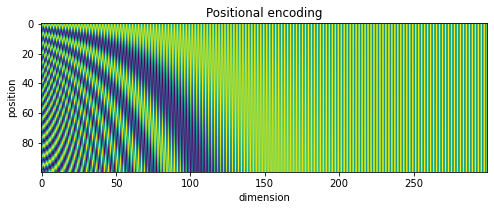

In [6]:
max_len = 100

def get_pe(p, i):
    k = i // 2
    if i % 2 == 0:
        return np.sin(p/(10000**(2*k/embedding_size)))
    else:
        return np.cos(p/(10000**(2*k/embedding_size)))

pe = np.zeros((embedding_size, max_len))
for p in range(max_len):
    for i in range(embedding_size):
        pe[i, p] = get_pe(p, i)
        
fig, ax = plt.subplots(figsize=(8, 5))
ax.imshow(pe.T[:100,:])
ax.set_title('Positional encoding')
ax.set_xlabel('dimension')
ax.set_ylabel('position')

plt.show()

pe = pe.T # for easier addition in the future operations
pe = torch.tensor(pe, requires_grad=False).to(device)

### Attention mask

In [7]:
def mask_seq(seq_lens):
    mask = torch.zeros((len(seq_lens), max(seq_lens))).bool()
    for i, seq_len in enumerate(seq_lens):
        mask[i, seq_len:] = True
    return mask.to(device)

### Encoder layer

In [8]:
class Encoder(Module):
    def __init__(self, embed_dim, num_heads, dropout, batch_first, norm_dim):
        super(Encoder, self).__init__()
        
        self.batch_first = batch_first
        self.norm_dim = norm_dim
        self.att = nn.MultiheadAttention(embed_dim=embed_dim,
                                         num_heads=num_heads,
                                         dropout=dropout,)
        self.fc = nn.Linear(embed_dim, embed_dim)
        self.fc.weight = xavier_uniform_(self.fc.weight)
    
    def forward(self, inp, pad_mask):
        # make batch second
        if self.batch_first:
            inp = inp.permute(1, 0, 2)        
        
        # inp, att_out: [seq dim, batch dim, embed dim]
        att_out, _ = self.att(inp, inp, inp, key_padding_mask=pad_mask)
        
        # out, fc_out: [batch dim, seq dim, embed dim]
        out = (att_out + inp).permute(1, 0, 2)
        out = F.layer_norm(out, out.shape[self.norm_dim:])
        out = F.layer_norm(self.fc(out) + out, out.shape[self.norm_dim:])
        
        # restore the original shape
        if not self.batch_first:
            out = out.permute(1, 0, 2)
        return out

### Network architecture

In [9]:
class Classifier(Module):
    def __init__(self):
        super(Classifier, self).__init__()

        self.embed = nn.Embedding(vocab_size, embedding_size)
        self.embed.load_state_dict(torch.load(embedding_path, map_location=torch.device(device)))
        self.embed.requires_grad = False
        
        self.encoder_1 = Encoder(
            embed_dim=embedding_size,
            num_heads=10,
            dropout=0.7,
            batch_first=False,
            norm_dim=1,
        )
        self.encoder_2 = Encoder(
            embed_dim=embedding_size,
            num_heads=5,
            dropout=0.7,
            batch_first=False,
            norm_dim=1,
        )

        self.fc = nn.Linear(embedding_size, 1)

    def forward(self, inp, seq_lens):
        # add positional encoding
        # out: [seq dim, batch dim, embed dim]
        out = self.embed(inp)
        for i in range(out.shape[1]):
            out[:, i, :] += pe[:out.shape[0], :]
        # padding mask
        pad_mask = mask_seq(seq_lens)
        # encoder
        out = self.encoder_1(out, pad_mask)
        out = self.encoder_2(out, pad_mask)
        # predict
        out = self.fc(out)
        out = out.squeeze(2)
        pred = torch.zeros((out.size(1), 1))
        for i, seq_len in enumerate(seq_lens):
            pred[i, 0] = out[:seq_len, i].mean()
        return pred

clf = Classifier().to(device)
torch.save(clf.state_dict(), 'save/hindi_hindi_initial.pt')

### Loss function and optimizer

In [10]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(clf.parameters(), lr=learning_rate)

### Measure performance on test data

In [11]:
def predict_test():
    losses = 0
    acc_cnt = 0
    cnt = 0
    preds = []
    true_labels = []
    clf.eval()
    with torch.no_grad():
        for texts, seq_lens, labels in test_loader:
            pred = clf(texts.to(device), seq_lens).detach().to('cpu')
            loss = criterion(pred, labels)
            losses += loss.detach().item() * len(texts)
            acc_cnt += sum((pred > 0) == (labels > 0)).item()
            preds.extend(pred.view(-1))
            true_labels.extend(labels.view(-1))
            cnt += texts.size(1)
    
    preds = np.array(preds) > 0
    macro_f1 = f1_score(true_labels, preds, average='macro')
    weighted_f1 = f1_score(true_labels, preds, average='weighted')
    return losses / cnt, acc_cnt / cnt, macro_f1, weighted_f1

## Training

In [12]:
def adjust_lr(epoch, batch_idx, total_batches):
    if epoch == 1:
        lr = (batch_idx+1)/total_batches*learning_rate # lr warm-up
        for g in optimizer.param_groups:
            g['lr'] = lr

In [13]:
clf.load_state_dict(torch.load('save/hindi_hindi_initial.pt'))

list_test_acc = []
early_stop = 5

for epoch in range(1, epochs + 1):
    losses = 0.
    acc_cnt = 0
    cnt = 0
    clf.train()
    train_batches = len(tqdm(train_loader))
    for i, (texts, seq_lens, labels) in enumerate(tqdm(train_loader)):
        adjust_lr(epoch, i, train_batches)
        optimizer.zero_grad()
        pred = clf(texts.to(device), seq_lens)
        loss = criterion(pred, labels)
        loss.backward()
        optimizer.step()
        losses += loss.detach().item() * len(texts)
        acc_cnt += sum((pred.to('cpu') > 0) == (labels > 0)).item()
        cnt += texts.size(1)

    epoch_loss = losses / cnt
    epoch_acc = acc_cnt / cnt
    test_loss, test_acc, test_macro_f1, test_weighted_f1 = predict_test()
    print(f'Epoch {epoch:2}: Train loss: {epoch_loss:.4f}, acc: {epoch_acc:.4f}. '
        f'Test loss: {test_loss:.4f}, acc: {test_acc:.4f}, '
        f'macro_f1: {test_macro_f1:.4f}, weighted_f1: {test_weighted_f1:.4f}',
        flush=True)

    list_test_acc.append(test_acc)
    if len(list_test_acc) > early_stop and max(list_test_acc[-early_stop:]) <= max(list_test_acc[:-early_stop]):
        print(f'Early stopping: test accuracy does not increase after {early_stop} epochs')
        break

100%|██████████| 146/146 [00:09<00:00, 15.88it/s]


Epoch  1: Train loss: 0.8841, acc: 0.5336. Test loss: 0.8424, acc: 0.5455, macro_f1: 0.5293, weighted_f1: 0.5364


100%|██████████| 146/146 [00:08<00:00, 16.31it/s]


Epoch  2: Train loss: 0.8676, acc: 0.5741. Test loss: 0.8465, acc: 0.5266, macro_f1: 0.4628, weighted_f1: 0.4477


100%|██████████| 146/146 [00:08<00:00, 16.85it/s]


Epoch  3: Train loss: 0.8181, acc: 0.6356. Test loss: 0.7596, acc: 0.6889, macro_f1: 0.6889, weighted_f1: 0.6885


100%|██████████| 146/146 [00:08<00:00, 16.67it/s]


Epoch  4: Train loss: 0.7208, acc: 0.7103. Test loss: 0.6500, acc: 0.7398, macro_f1: 0.7393, weighted_f1: 0.7402


100%|██████████| 146/146 [00:08<00:00, 16.76it/s]


Epoch  5: Train loss: 0.5896, acc: 0.7787. Test loss: 0.6059, acc: 0.7519, macro_f1: 0.7512, weighted_f1: 0.7523


100%|██████████| 146/146 [00:08<00:00, 16.61it/s]


Epoch  6: Train loss: 0.5300, acc: 0.8076. Test loss: 0.7488, acc: 0.6844, macro_f1: 0.6784, weighted_f1: 0.6748


100%|██████████| 146/146 [00:08<00:00, 16.79it/s]


Epoch  7: Train loss: 0.4524, acc: 0.8465. Test loss: 0.7163, acc: 0.7155, macro_f1: 0.7143, weighted_f1: 0.7128


100%|██████████| 146/146 [00:08<00:00, 16.59it/s]


Epoch  8: Train loss: 0.4103, acc: 0.8604. Test loss: 0.6116, acc: 0.7724, macro_f1: 0.7699, weighted_f1: 0.7718


100%|██████████| 146/146 [00:08<00:00, 16.77it/s]


Epoch  9: Train loss: 0.3761, acc: 0.8771. Test loss: 0.6405, acc: 0.7648, macro_f1: 0.7623, weighted_f1: 0.7643


100%|██████████| 146/146 [00:08<00:00, 16.82it/s]


Epoch 10: Train loss: 0.3143, acc: 0.9014. Test loss: 0.6786, acc: 0.7754, macro_f1: 0.7705, weighted_f1: 0.7733


100%|██████████| 146/146 [00:08<00:00, 16.47it/s]


Epoch 11: Train loss: 0.2819, acc: 0.9097. Test loss: 0.7330, acc: 0.7777, macro_f1: 0.7720, weighted_f1: 0.7749


100%|██████████| 146/146 [00:08<00:00, 16.59it/s]


Epoch 12: Train loss: 0.2591, acc: 0.9198. Test loss: 0.8449, acc: 0.7420, macro_f1: 0.7416, weighted_f1: 0.7407


100%|██████████| 146/146 [00:08<00:00, 16.90it/s]


Epoch 13: Train loss: 0.2214, acc: 0.9357. Test loss: 0.7784, acc: 0.7709, macro_f1: 0.7701, weighted_f1: 0.7712


100%|██████████| 146/146 [00:08<00:00, 16.61it/s]


Epoch 14: Train loss: 0.1937, acc: 0.9430. Test loss: 0.8224, acc: 0.7610, macro_f1: 0.7594, weighted_f1: 0.7610


100%|██████████| 146/146 [00:08<00:00, 16.31it/s]


Epoch 15: Train loss: 0.1709, acc: 0.9530. Test loss: 0.8825, acc: 0.7610, macro_f1: 0.7606, weighted_f1: 0.7614


100%|██████████| 146/146 [00:08<00:00, 16.84it/s]


Epoch 16: Train loss: 0.1343, acc: 0.9659. Test loss: 0.9375, acc: 0.7618, macro_f1: 0.7612, weighted_f1: 0.7621
Early stopping: test accuracy does not increase after 5 epochs


In [14]:
# save final model
torch.save(clf.state_dict(), 'save/hindi_hindi_final_clf.pt')

## Batch statistics

In [15]:
def train(epochs):
    # restore model to untrained
    clf.load_state_dict(torch.load('save/hindi_hindi_initial.pt'))
    
    # store test accuracy and macro-f1
    list_test_acc = []
    list_test_macro_f1 = []
    
    # train
    for epoch in range(1, epochs + 1):
        losses = 0.
        acc_cnt = 0
        cnt = 0
        clf.train()
        for texts, seq_lens, labels in train_loader:
            optimizer.zero_grad()
            pred = clf(texts.to(device), seq_lens)
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()
            losses += loss.detach().item() * len(texts)
            acc_cnt += sum((pred.to('cpu') > 0) == (labels > 0)).item()
            cnt += texts.size(1)

        epoch_loss = losses / cnt
        epoch_acc = acc_cnt / cnt
        test_loss, test_acc, test_macro_f1, test_weighted_f1 = predict_test()

        list_test_acc.append(test_acc)
        list_test_macro_f1.append(test_macro_f1)
        
    return list_test_acc, list_test_macro_f1

def batch_train(ntime, epochs):
    list_test_acc = []
    list_test_macro_f1 = []
    for i in range(ntime):
        acc, macro_f1 = train(epochs=epochs)
        list_test_acc.append(acc)
        list_test_macro_f1.append(macro_f1)
        print(f'Trained {i+1} time(s)')
    
    return list_test_acc, list_test_macro_f1

def plot_results(list_test_acc, list_test_macro_f1):
    # accuracy plot
    mean_acc = [np.mean([l[i] for l in list_test_acc if len(l) > i]) for i in range(max(len(li) for li in list_test_acc))]

    fig = go.Figure()
    for i, acc_curve in enumerate(list_test_acc):
        fig.add_trace(go.Scatter(
            x=list(range(1, len(acc_curve)+1)), 
            y=acc_curve,
            mode='lines',
            name=f'model {i+1}',
            opacity=0.3,
        ))
    fig.add_trace(go.Scatter(
        x=list(range(1, len(mean_acc)+1)), 
        y=mean_acc,
        mode='lines+markers',
        line_color='blue',
        name='mean',
    ))

    fig.update_layout(
        title='Accuracy plot',
        xaxis_title='Epoch',
        yaxis_title='Accuracy'
    )

    fig.show()

    # macro-f1 plot
    mean_mac = [np.mean([l[i] for l in list_test_macro_f1 if len(l) > i]) for i in range(max(len(li) for li in list_test_macro_f1))]

    fig = go.Figure()
    for i, mac_curve in enumerate(list_test_macro_f1):
        fig.add_trace(go.Scatter(
            x=list(range(len(mac_curve))), 
            y=mac_curve,
            mode='lines',
            name=f'model {i+1}',
            opacity=0.3,
        ))
    fig.add_trace(go.Scatter(
        x=list(range(len(mean_mac))), 
        y=mean_mac,
        mode='lines+markers',
        line_color='blue',
        name='mean',
    ))

    fig.update_layout(
        title='Macro-f1 plot',
        xaxis_title='Epoch',
        yaxis_title='Macro-f1'
    )

    fig.show()

In [16]:
# list_test_acc, list_test_macro_f1 = batch_train(ntime=5, epochs=15)
# plot_results(list_test_acc, list_test_macro_f1)